# First script

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

(512, 512)
2 255
uint8


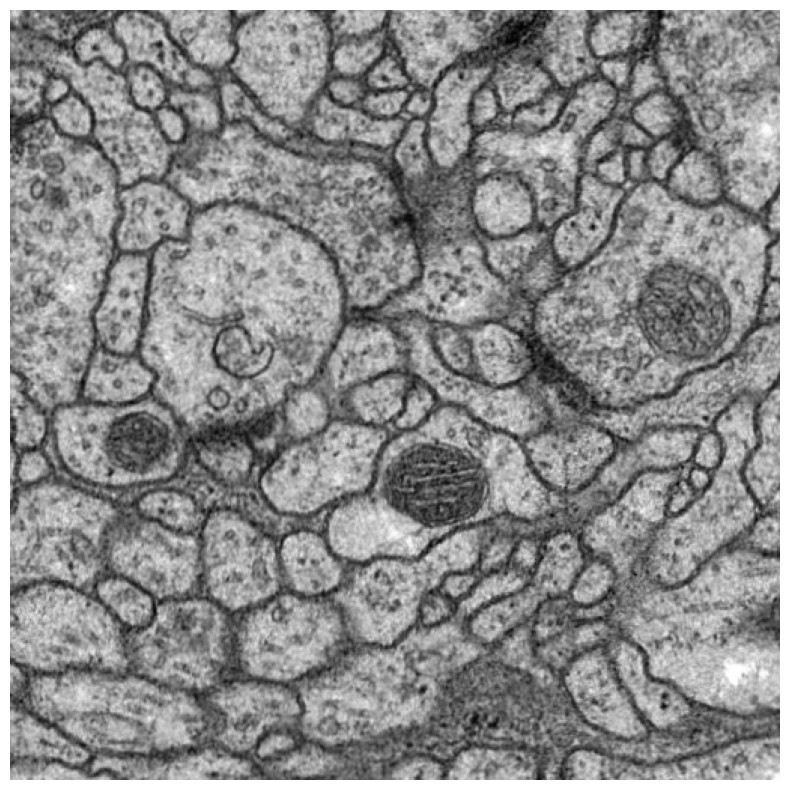

In [2]:
folder = 'data/train_images/'

# read train_images
def read_train_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        images.append(img)
    return images

images = read_train_images(folder)

# show the first image
print(images[0].shape)
print(images[0].min(),images[0].max())
print(images[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(images[0], cmap = 'gray')
plt.axis('off')
plt.show()

(512, 512)
0 255
uint8


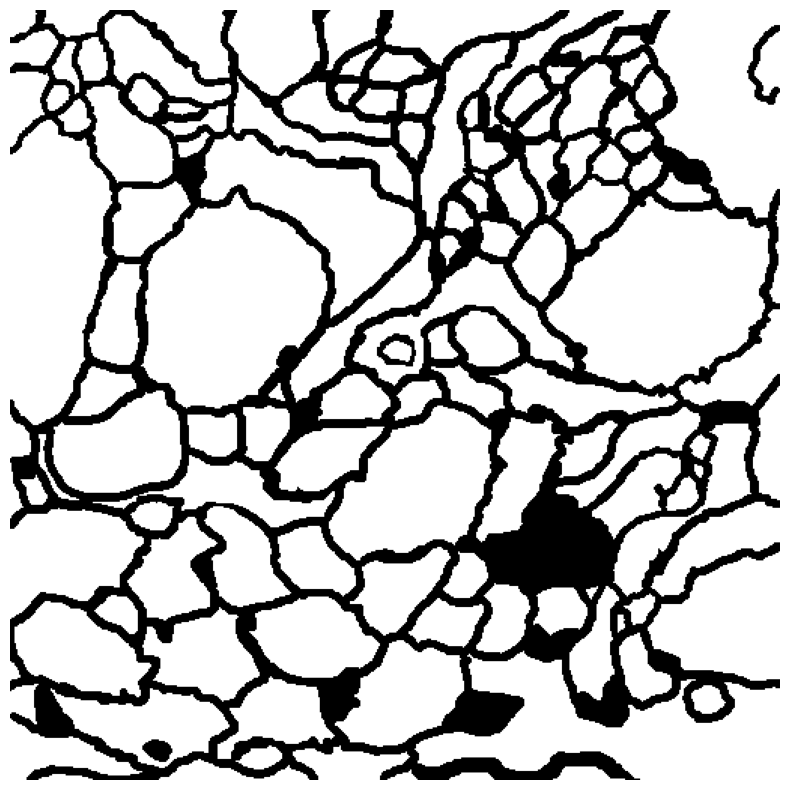

In [3]:
folder = 'data/train_labels/'

labels = read_train_images(folder)

# show the first image
print(labels[0].shape)
print(labels[0].min(),labels[0].max())
print(labels[0].dtype)
plt.figure(figsize=(10, 10))
plt.imshow(labels[0], cmap = 'gray')
plt.axis('off')
plt.show()

This is the reason why we import the images as one channel images: 

In [12]:
# Check if all three channels are identical
# is_grayscale = (images[0][:, :, 0] == images[0][:, :, 1]).all() and (images[0][:, :, 1] == images[0][:, :, 2]).all()
# print("Is the image grayscale?", is_grayscale)

ValueError: num must be an integer with 1 <= num <= 64, not 65

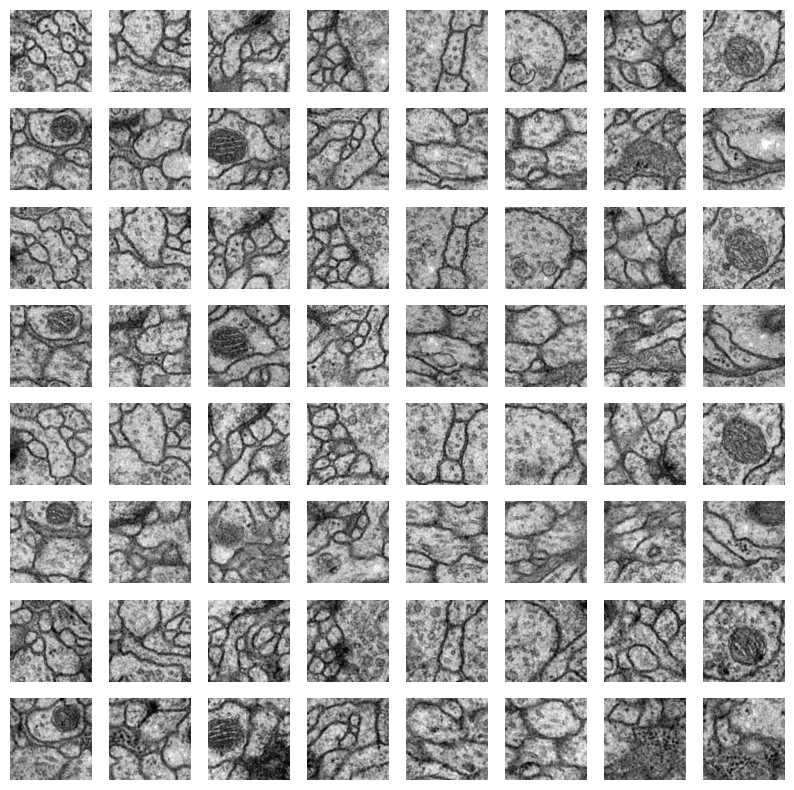

In [11]:
# do patches of the images, of 128x128
def create_patches(images, patch_size=128):
    patches = []
    for image in images:
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
    return patches

# create patches of the first image
patches_images = create_patches(images, patch_size=128)

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_images):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

ValueError: num must be an integer with 1 <= num <= 64, not 65

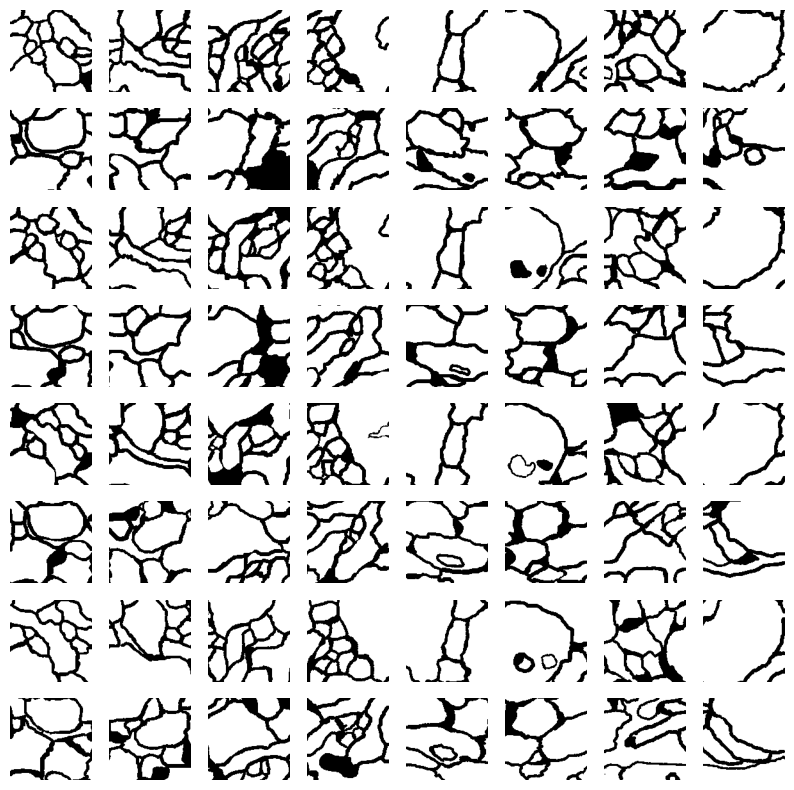

In [12]:
# create patches of the first image
patches_labels = create_patches(labels, patch_size=128)

# show patches
plt.figure(figsize=(10, 10))
for i, patch in enumerate(patches_labels):
    plt.subplot(8, 8, i+1)
    plt.imshow(patch, cmap='gray')
    plt.axis('off')
plt.show()

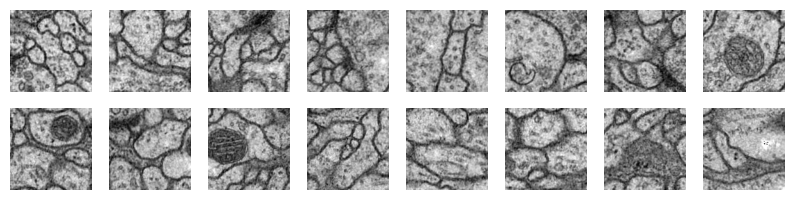

In [13]:
# show the images and above the labels use patches_images and patches_labels
plt.figure(figsize=(10, 10))
for i in range(0, 16):
    plt.subplot(8, 8, i+1)
    #plt.imshow(patches_images[i], cmap='gray')
    plt.imshow(patches_images[i]-patches_labels[i], cmap='gray')
    plt.axis('off')
plt.show()


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):  # grayscale: in_channels=1
        super(UNet, self).__init__()

        # Encoder
        self.enc1 = self.double_conv(in_channels, 64)
        self.enc2 = self.double_conv(64, 128)
        self.enc3 = self.double_conv(128, 256)
        self.enc4 = self.double_conv(256, 512)

        # Bottleneck
        self.bottleneck = self.double_conv(512, 1024)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = self.double_conv(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = self.double_conv(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.double_conv(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.double_conv(128, 64)

        # Final output
        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((e4, d4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((e3, d3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((e2, d2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((e1, d1), dim=1)
        d1 = self.dec1(d1)

        return torch.sigmoid(self.out_conv(d1))  # for binary segmentation

# Example
model = UNet(in_channels=1, out_channels=1)
#x = torch.randn(1, 1, 128, 128)  # grayscale image
x = patches_images[0]  # use the first patch
x = torch.tensor(x, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # add batch and channel dimensions
y = model(x)
print(y.shape)  # should be [1, 1, 128, 128]

torch.Size([1, 1, 128, 128])


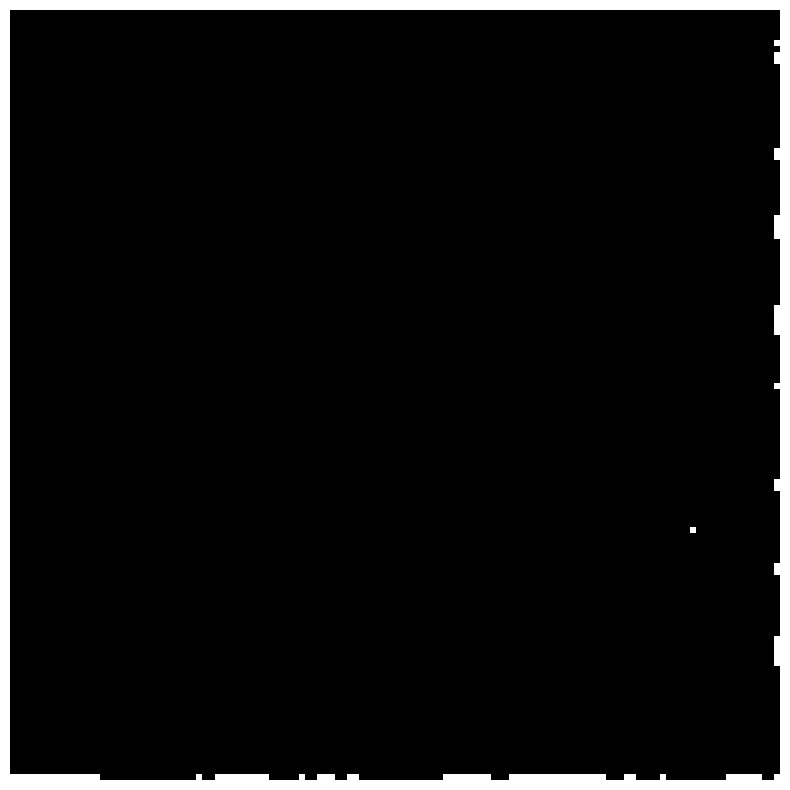

In [15]:
predicted_mask = (y > 0.5).float()  # threshold at 0.5

# see output
plt.figure(figsize=(10, 10))
plt.imshow(predicted_mask[0][0].detach().numpy(), cmap='gray')
plt.axis('off')
plt.show()

In [16]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("L")
        label = Image.open(label_path).convert("L")


        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

In [17]:
from torch.utils.data import Dataset
from PIL import Image
import os
from torchvision import transforms

class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, patch_size=128):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.patch_size = patch_size
        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path).convert("L")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        # Convert PIL images to numpy arrays for patch creation
        image_np = np.array(image)
        label_np = np.array(label)

        # Create patches
        image_patches = self.create_patches(image_np, self.patch_size)
        label_patches = self.create_patches(label_np, self.patch_size)

        return image_patches, label_patches

    # Function to create patches of the images
    def create_patches(self, image, patch_size=128):
        patches = []
        for i in range(0, image.shape[0], patch_size):
            for j in range(0, image.shape[1], patch_size):
                patch = image[i:i+patch_size, j:j+patch_size]
                if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                    patches.append(patch)
        return patches

In [18]:
import torch
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0,1] FloatTensor
])

dataset = CellSegmentationDataset("data/train_images", "data/train_labels", transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)  # 16 images, so batch size 4

In [19]:
for batch_idx, (images, masks) in enumerate(dataloader):
    if images is None or masks is None:
        print(f"Found None at batch {batch_idx}")
        continue

In [20]:
model = UNet(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.BCELoss()

In [21]:
from tqdm import tqdm

num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    with tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch_idx, (images, masks) in pbar:
            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"Batch Loss": loss.item()})

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch 1/10:   0%|          | 0/2 [00:00<?, ?it/s]


TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)


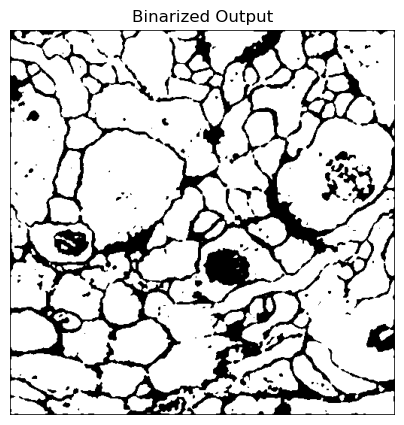

In [35]:
# Binarize the output
threshold = 0.8 # Define a threshold (e.g., 0.5 for probabilities)
binary_output = (outputs[0, 0] > threshold).float()  # Binarize the output

# Visualize the binarized output
plt.figure(figsize=(5, 5))
plt.imshow(binary_output.detach().numpy(), cmap='gray')
plt.axis('off')
plt.title("Binarized Output")
plt.show()

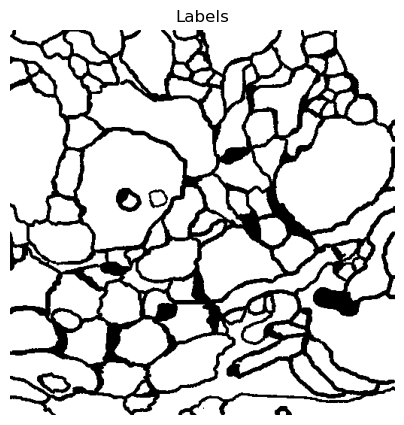

In [30]:
# plot labels_o5.png
plt.figure(figsize=(5, 5))
plt.imshow(labels[3], cmap='gray')
plt.axis('off')
plt.title("Labels")
plt.show()


In [22]:
num_epochs = 10
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_idx, (images, masks) in enumerate(dataloader):
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, masks)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, tuple of ints padding = 0, tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
 * (Tensor input, Tensor weight, Tensor bias = None, tuple of ints stride = 1, str padding = "valid", tuple of ints dilation = 1, int groups = 1)
      didn't match because some of the arguments have invalid types: (!list of []!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, !int!)
